In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


setup and path configuration

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

DATASET_PATH = '/content/drive/MyDrive/coil-20-proc'

# List a few files to verify the path is correct
try:
    print(f"Sample files in directory: {os.listdir(DATASET_PATH)[:5]}")
except FileNotFoundError:
    print("Error: The path provided was not found. Please check the folder name.")

Sample files in directory: ['obj16__20.png', 'obj14__42.png', 'obj16__71.png', 'obj15__41.png', 'obj16__4.png']


feature extraction HOG

In [ ]:
def extract_features(path):
    features = []
    labels = []

    # Get all image files
    valid_images = [f for f in os.listdir(path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    print(f"Processing {len(valid_images)} images...")

    for filename in valid_images:
        # Extract label from filename (e.g., 'obj1__0.png' -> 1)
        try:
            label = int(filename.split('__')[0].replace('obj', ''))
        except:
            continue

        img_path = os.path.join(path, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        if img is None: continue

        # Standardize size for feature extraction
        img = cv2.resize(img, (64, 64))

        # HOG parameters: orientations (directions), pixels per cell (local area)
        fd = hog(img, orientations=9, pixels_per_cell=(8, 8),
                 cells_per_block=(2, 2), visualize=False)

        features.append(fd)
        labels.append(label)

    return np.array(features), np.array(labels)

X, y = extract_features(DATASET_PATH)
print(f"Data Loaded. Feature vector size per image: {X.shape[1]}")
print(f"Number of images (Rows): {X.shape[0]}")
print(f"Number of HOG features per image (Columns): {X.shape[1]}")
# Print the raw feature matrix
print("--- HOG Feature Matrix (X) ---")
print(X)

# Print specific details about the matrix
print(f"\nMatrix Shape: {X.shape[0]} images x {X.shape[1]} features")
print("\nFirst row (first image) raw features:")
print(X[0])

Processing 1440 images...
Data Loaded. Feature vector size per image: 1764
Number of images (Rows): 1440
Number of HOG features per image (Columns): 1764
--- HOG Feature Matrix (X) ---
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.01022115 0.36350561 ... 0.         0.         0.        ]
 [0.         0.         0.35385039 ... 0.         0.         0.        ]]

Matrix Shape: 1440 images x 1764 features

First row (first image) raw features:
[0. 0. 0. ... 0. 0. 0.]


feature normalisation and splitting

In [ ]:
# Split: 80% Training, 20% Testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

# Normalization (Crucial for SVM and PCA)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data successfully split and normalized.")

Data successfully split and normalized.


dimensionality reduction : PCA vs LDA

In [ ]:
# PCA: Retaining 95% of the variance
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# LDA: Max components is (number of classes - 1)
lda = LDA()
X_train_lda = lda.fit_transform(X_train_scaled, y_train)
X_test_lda = lda.transform(X_test_scaled)

print(f"Dimensions - Original: {X_train.shape[1]}")
print(f"Dimensions - PCA: {X_train_pca.shape[1]}")
print(f"Dimensions - LDA: {X_train_lda.shape[1]}")

Dimensions - Original: 1764
Dimensions - PCA: 266
Dimensions - LDA: 19


training and evaluation: Confusion Matrix

--- Classification Report (PCA + SVM) ---
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00        14
           3       1.00      1.00      1.00        14
           4       1.00      1.00      1.00        14
           5       1.00      1.00      1.00        15
           6       1.00      1.00      1.00        14
           7       1.00      1.00      1.00        15
           8       1.00      1.00      1.00        15
           9       1.00      1.00      1.00        14
          10       1.00      1.00      1.00        15
          11       1.00      1.00      1.00        15
          12       1.00      1.00      1.00        14
          13       1.00      1.00      1.00        15
          14       1.00      1.00      1.00        14
          15       1.00      1.00      1.00        15
          16       1.00      1.00      1.00        14
          17       1.00      1.00      

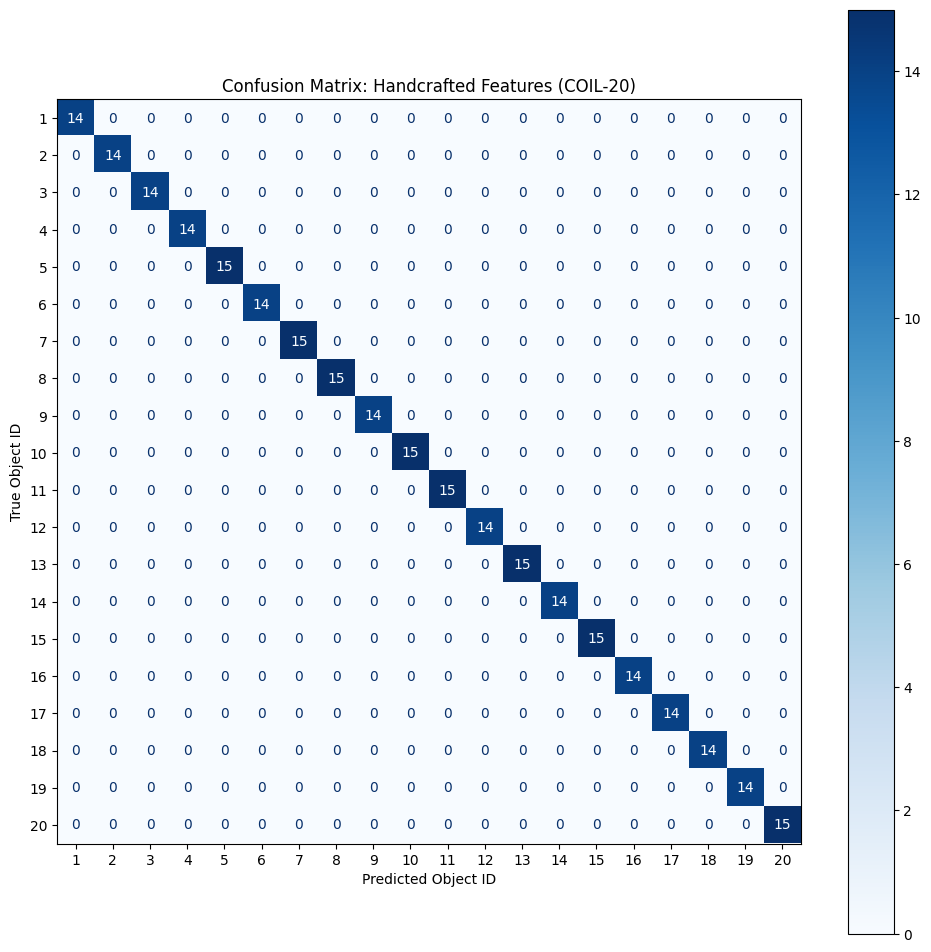

   FINAL TEST ACCURACY: 100.00%

--- HOG FEATURE MATRIX (Sample) ---
[[  0.41345097  20.36195325 -18.37482579 ...  -0.85802843   0.75652544
    0.07599205]
 [-12.71546564 -17.4004818  -10.59169732 ...   0.37243999   0.38278344
   -0.4254987 ]
 [ 14.15620584  17.30544331  -1.15091216 ...   0.32265773  -0.0356591
   -0.90722356]
 [ -9.06035675  -2.84771258  13.97695632 ...  -0.05058571  -0.64686184
   -0.39380074]
 [ -8.26571397  10.47684595  15.7931809  ...  -0.63679112  -0.18512722
   -1.52817166]]

--- ACTUAL VS PREDICTED LABELS (First 20) ---
Actual:    [15  3 12  1 14  1  2  8  6  2  2 19  2 17 20  7  9  7  3  7]
Predicted: [15  3 12  1 14  1  2  8  6  2  2 19  2 17 20  7  9  7  3  7]

Total Test Images: 288
Number of Misclassifications: 0


In [ ]:
# Model: Linear SVM
clf = SVC(kernel='linear', C=1.0)
clf.fit(X_train_pca, y_train)

# Predict
y_pred = clf.predict(X_test_pca)

# Display Results
print("--- Classification Report (PCA + SVM) ---")
print(classification_report(y_test, y_pred))

# Plot Confusion Matrix
fig, ax = plt.subplots(figsize=(12, 12))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, cmap='Blues')
plt.title("Confusion Matrix: Handcrafted Features (COIL-20)")
plt.xlabel("Predicted Object ID")
plt.ylabel("True Object ID")
plt.show()


# 1. Compute Accuracy
final_accuracy = accuracy_score(y_test, y_pred)

# 2. Print everything clearly
print("========================================")
print(f"   FINAL TEST ACCURACY: {final_accuracy * 100:.2f}%")
print("========================================\n")

print("--- HOG FEATURE MATRIX (Sample) ---")
# Printing the first 5 rows of the test matrix so it doesn't spam the whole screen
print(X_test_pca[:5])

print("\n--- ACTUAL VS PREDICTED LABELS (First 20) ---")
print(f"Actual:    {y_test[:20]}")
print(f"Predicted: {y_pred[:20]}")

# 3. Quick Calculation of Errors
errors = (y_test != y_pred).sum()
print(f"\nTotal Test Images: {len(y_test)}")
print(f"Number of Misclassifications: {errors}")

alternative feature extraction: wavelets

In [ ]:
import pywt

def extract_wavelet_features(path):
    features = []
    labels = []
    files = sorted([f for f in os.listdir(path) if f.lower().endswith(('.png', '.jpg'))])

    for filename in files:
        label = int(filename.split('__')[0].replace('obj', ''))
        img = cv2.imread(os.path.join(path, filename), cv2.IMREAD_GRAYSCALE)

        if img is not None:
            img = cv2.resize(img, (64, 64))
            # 2D Wavelet Transform (using Haar wavelet)
            coeffs = pywt.dwt2(img, 'haar')
            LL, (LH, HL, HH) = coeffs
            # Use the approximation coefficients (LL) as features
            features.append(LL.flatten())
            labels.append(label)

    return np.array(features), np.array(labels)

# You can run this to see if Wavelets perform better than HOG
X_wav, y_wav = extract_wavelet_features(DATASET_PATH)
print(f"Wavelet features extracted: {X_wav.shape}")

Wavelet features extracted: (1440, 1024)


robustness test using addition of noise

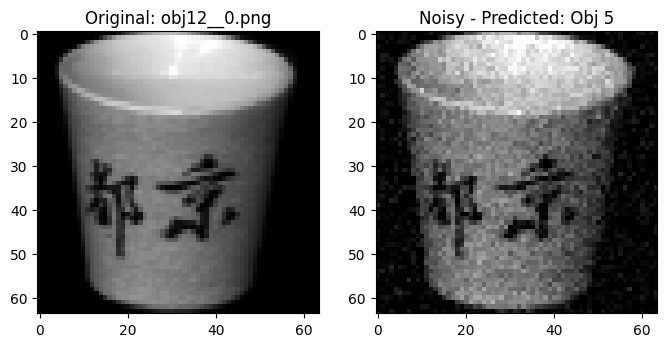

In [ ]:
import random

# 1. Pick a random image from your Drive path
random_file = random.choice([f for f in os.listdir(DATASET_PATH) if f.lower().endswith(('.png', '.jpg'))])
img_path = os.path.join(DATASET_PATH, random_file)

# 2. Preprocess: Load, Resize, and Add Noise
raw_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
raw_img = cv2.resize(raw_img, (64, 64))

# Add Gaussian Noise
noise = np.random.normal(0, 15, raw_img.shape)
noisy_img = np.clip(raw_img + noise, 0, 255).astype(np.uint8)

# 3. Feature Extraction (HOG) from the noisy image
fd_noisy = hog(noisy_img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2))
fd_noisy = fd_noisy.reshape(1, -1) # Reshape for the model

# 4. Pass through the Pipeline (Scaler -> PCA -> Model)
fd_scaled = scaler.transform(fd_noisy)
fd_pca = pca.transform(fd_scaled)
prediction = clf.predict(fd_pca)

# 5. Visualize Results
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title(f"Original: {random_file}")
plt.imshow(raw_img, cmap='gray')

plt.subplot(1, 2, 2)
plt.title(f"Noisy - Predicted: Obj {prediction[0]}")
plt.imshow(noisy_img, cmap='gray')
plt.show()

performance analysis: clean vs noisy

--- Performance Analysis ---
Accuracy on Clean Data: 100.00%
Accuracy on Noisy Data: 86.81%
Drop in Performance: 13.19%


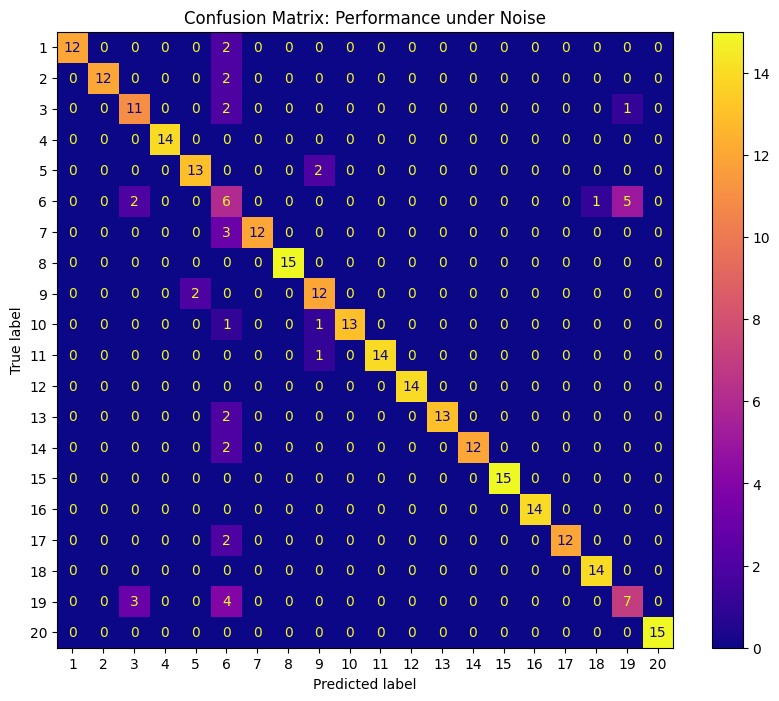

In [ ]:
# 1. Create a version of the test set with Gaussian noise
noise_factor = 0.3
X_test_noisy = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape)

# 2. Run the noisy data through the normalization and PCA steps
X_test_noisy_scaled = scaler.transform(X_test_noisy)
X_test_noisy_pca = pca.transform(X_test_noisy_scaled)

# 3. Get predictions for both clean and noisy data
y_pred_clean = clf.predict(X_test_pca)
y_pred_noisy = clf.predict(X_test_noisy_pca)

# 4. Compare Performance
clean_acc = accuracy_score(y_test, y_pred_clean)
noisy_acc = accuracy_score(y_test, y_pred_noisy)

print(f"--- Performance Analysis ---")
print(f"Accuracy on Clean Data: {clean_acc * 100:.2f}%")
print(f"Accuracy on Noisy Data: {noisy_acc * 100:.2f}%")
print(f"Drop in Performance: {(clean_acc - noisy_acc) * 100:.2f}%")

# 5. Analyze Confusion Matrix for Noisy Data
fig, ax = plt.subplots(figsize=(10, 8))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_noisy, ax=ax, cmap='plasma')
plt.title("Confusion Matrix: Performance under Noise")
plt.show()

lbp

Extracting LBP features from 1440 images...

   LBP TEST ACCURACY: 39.24%

--- LBP FEATURE MATRIX (Sample) ---
[[0.0222168  0.03491211 0.00512695 0.00268555 0.00366211 0.00390625
  0.00439453 0.00585937 0.01660156 0.02685547 0.03540039 0.05493164
  0.13623047 0.05273437 0.01806641 0.01220703 0.00878906 0.00683594
  0.00463867 0.00585937 0.00756836 0.0065918  0.00415039 0.01489258
  0.23291016 0.27197266]
 [0.02416992 0.03198242 0.00537109 0.00488281 0.00244141 0.00537109
  0.00439453 0.0065918  0.01367187 0.02294922 0.03051758 0.05371094
  0.13769531 0.04931641 0.01904297 0.01074219 0.00878906 0.0065918
  0.00805664 0.00561523 0.00732422 0.00756836 0.00805664 0.01660156
  0.22924805 0.27929687]
 [0.02270508 0.01489258 0.00976562 0.00585937 0.00732422 0.00512695
  0.00512695 0.00878906 0.01269531 0.01708984 0.02856445 0.06640625
  0.10571289 0.05273437 0.02075195 0.01025391 0.00512695 0.00390625
  0.00317383 0.00366211 0.00512695 0.00415039 0.00488281 0.00512695
  0.41113281 0.15991211]

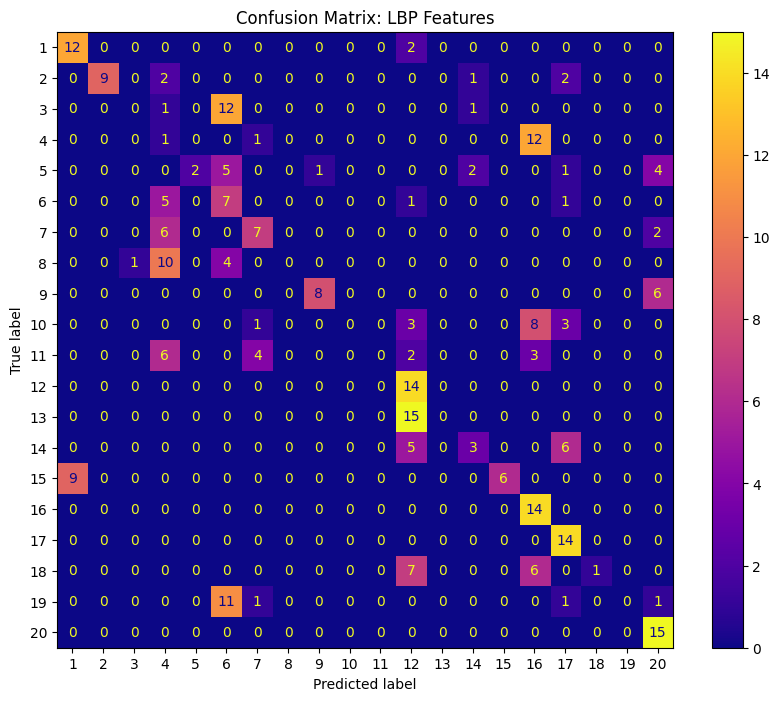

In [ ]:
from skimage.feature import local_binary_pattern

def extract_lbp_features(path):
    features = []
    labels = []
    files = sorted([f for f in os.listdir(path) if f.lower().endswith(('.png', '.jpg'))])

    # LBP Parameters: radius and number of points to check around a pixel
    radius = 3
    n_points = 8 * radius

    print(f"Extracting LBP features from {len(files)} images...")
    for filename in files:
        label = int(filename.split('__')[0].replace('obj', ''))
        img = cv2.imread(os.path.join(path, filename), cv2.IMREAD_GRAYSCALE)

        if img is not None:
            img = cv2.resize(img, (64, 64))
            # Compute LBP texture map
            lbp = local_binary_pattern(img, n_points, radius, method='uniform')
            # Create a histogram of the LBP values to form the feature vector
            (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))

            # Normalize histogram (Preprocessing/Normalization)
            hist = hist.astype("float")
            hist /= (hist.sum() + 1e-7)

            features.append(hist)
            labels.append(label)

    return np.array(features), np.array(labels)

# 1. Extraction
X_lbp, y_lbp = extract_lbp_features(DATASET_PATH)

# 2. Train/Test Split
X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(X_lbp, y_lbp, test_size=0.2, random_state=42, stratify=y_lbp)

# 3. Model Training
lbp_model = SVC(kernel='linear')
lbp_model.fit(X_train_l, y_train_l)
y_pred_l = lbp_model.predict(X_test_l)

# 4. PRINTS (Matrix, Labels, and Accuracy)
print("\n" + "="*40)
print(f"   LBP TEST ACCURACY: {accuracy_score(y_test_l, y_pred_l) * 100:.2f}%")
print("="*40)

print("\n--- LBP FEATURE MATRIX (Sample) ---")
# Each row is a histogram of texture patterns
print(X_lbp[:5])

print(f"\nMatrix Shape: {X_lbp.shape[0]} images x {X_lbp.shape[1]} texture bins")

print("\n--- ACTUAL VS PREDICTED (LBP) ---")
print(f"Actual:    {y_test_l[:15]}")
print(f"Predicted: {y_pred_l[:15]}")

# 5. Analysis (Confusion Matrix)

fig, ax = plt.subplots(figsize=(10, 8))
ConfusionMatrixDisplay.from_predictions(y_test_l, y_pred_l, ax=ax, cmap='plasma')
plt.title("Confusion Matrix: LBP Features")
plt.show()